In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
whos

Interactive namespace is empty.


In [3]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            187          29         153           3           4         152
Swap:            11           1          10


In [4]:
!nvidia-smi

Mon Sep 13 18:04:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   38C    P0    65W / 300W |  15660MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

|    0   N/A  N/A     40515      C   ...a/anaconda3/bin/python3.8    15657MiB |
|    1   N/A  N/A     40515      C   ...a/anaconda3/bin/python3.8      453MiB |
|    2   N/A  N/A     40515      C   ...a/anaconda3/bin/python3.8      453MiB |
|    3   N/A  N/A     40515      C   ...a/anaconda3/bin/python3.8      453MiB |
+-----------------------------------------------------------------------------+


In [5]:
import nvidia_smi

nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", (info.total/1024/1024/1024))
print("Free memory:", (info.free/1024/1024/1024))
print("Used memory:", (info.used/1024/1024/1024))

nvidia_smi.nvmlShutdown()

Total memory: 15.78173828125
Free memory: 0.48828125
Used memory: 15.29345703125


In [6]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

from functools import partial
from tqdm import tqdm
from umap import UMAP
tqdm = partial(tqdm, position=0, leave=True) 

In [7]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
#data_dir = '../Assets/fc_mats/'
data_dir = '../Assets/fc_mats_32smooth/'

In [8]:
files = [file for file in os.listdir(data_dir) if file.endswith('.npz')]
files.sort()

In [9]:
# Check if subject has .nii file
has_file = np.array([os.path.exists(os.path.join(data_dir,sub + '.npz')) for sub in df['bids_folder'].values])
print(has_file.mean())
assert has_file.mean()==1.0, 'fuck'

1.0


In [10]:
%%time 
# LOAD DATA
n_subs = len(df)
data_size = np.hstack((n_subs,np.load(os.path.join(data_dir,df['bids_folder'].values[0] + '.npz'))['data'].shape))
data = np.zeros(data_size)
#for s in tqdm(range(len(df))):
for s in range(n_subs):
    sub = df['bids_folder'].values[s]
    datum = np.load(os.path.join(data_dir,sub + '.npz'))['data']
    data[s,:,:,:,:] = datum

CPU times: user 39.1 s, sys: 3.91 s, total: 43 s
Wall time: 50 s


In [11]:
df = df.iloc[0:n_subs]

In [12]:
hasnans = np.array([np.isnan(data[s,:,:,:,:]).sum()!=0 for s in range(data.shape[0])])
df = df.iloc[~hasnans]
data = data[~hasnans,:,:,:,:]

In [13]:
data.shape

(1048, 32, 32, 32, 51)

In [14]:
assert np.isnan(data).mean()==0.0, 'you f****d up'

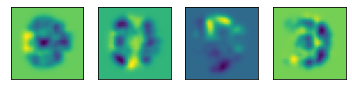

In [15]:
plt.subplot(1,4,1);plt.imshow(data[10,:,:,20,0]);plt.xticks([]);plt.yticks([]);
plt.subplot(1,4,2);plt.imshow(data[np.random.randint(0,data.shape[0]),:,:,20,0]);plt.xticks([]);plt.yticks([]);
plt.subplot(1,4,3);plt.imshow(data[np.random.randint(0,data.shape[0]),20,:,:,0]);plt.xticks([]);plt.yticks([]);
plt.subplot(1,4,4);plt.imshow(data[np.random.randint(0,data.shape[0]),:,20,:,0]);plt.xticks([]);plt.yticks([]);

In [16]:
%%time
from helper_funcs import *
from importlib import reload
import make_models
reload(make_models)
del make_models
from make_models import *

from IPython import display
import sys
from sklearn.decomposition import PCA
import seaborn as sns

import tensorflow as tf
reload(tf)

CPU times: user 54.8 ms, sys: 10.4 ms, total: 65.2 ms
Wall time: 245 ms


<module 'tensorflow' from '/data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/__init__.py'>

In [17]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [18]:
import make_models
reload(make_models)
from make_models import *
batch_size = 16
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(input_shape=tuple(data_size[1::]),
                   latent_dim = 8, 
                   batch_size = batch_size, 
                   disentangle = True, 
                   gamma = 1,
                   kernel_size = 3,
                   filters = 8,
                   intermediate_dim = 128,
                   nlayers = 2,
                   learning_rate=0.001)

In [19]:
tuple(data_size)

(1048, 32, 32, 32, 51)

In [20]:
patients = df['DX_GROUP'].values==1
controls = df['DX_GROUP'].values==2

In [21]:
loss = list()
c_sim = list()
all_rsas = list()

In [22]:
tf.__version__

'2.3.1'

In [23]:
def fit_rsa(rdm_data,rdm_model):
    return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]

In [24]:
def get_batch_rsas(z_encoder,s_encoder,df,n=400):

    asd_idx = np.nonzero(~np.isnan(df['ADOS_TOTAL'].values))[0][0:n]

    z_embedding = z_encoder.predict(data[patients,:,:,:,:][asd_idx,:,:,:,:])[2]
    s_embedding = s_encoder.predict(data[patients,:,:,:,:][asd_idx,:,:,:,:])[2]

    rdm_age = make_RDM(df['AGE_AT_SCAN'].values[patients][asd_idx])
    rdm_sex = make_RDM(df['SEX'].values[patients][asd_idx],data_scale='ordinal')
    rdm_fiq = make_RDM(df['FIQ'].values[patients][asd_idx])
    rdm_dsm = make_RDM(df['DSM_IV_TR'].values[patients][asd_idx],data_scale='ordinal')
    rdm_site = make_RDM(df['site'].values[patients][asd_idx],data_scale='ordinal')
    rdm_adosTotal = make_RDM(df['ADOS_TOTAL'].values[patients][asd_idx])

    rdm_z = make_RDM(z_embedding)
    rdm_s = make_RDM(s_embedding)

    batch_rsas = list()

    batch_rsas.append(fit_rsa(rdm_s,rdm_age))
    batch_rsas.append(fit_rsa(rdm_s,rdm_sex))
    batch_rsas.append(fit_rsa(rdm_s,rdm_fiq))
    batch_rsas.append(fit_rsa(rdm_s,rdm_dsm))
    batch_rsas.append(fit_rsa(rdm_s,rdm_site))
    batch_rsas.append(fit_rsa(rdm_s,rdm_adosTotal))

    batch_rsas.append(fit_rsa(rdm_z,rdm_age))
    batch_rsas.append(fit_rsa(rdm_z,rdm_sex))
    batch_rsas.append(fit_rsa(rdm_z,rdm_fiq))
    batch_rsas.append(fit_rsa(rdm_z,rdm_dsm))
    batch_rsas.append(fit_rsa(rdm_z,rdm_site))
    batch_rsas.append(fit_rsa(rdm_z,rdm_adosTotal))
    
    return batch_rsas

In [25]:
def cvae_dashboard(i,cvae,z_encoder,s_encoder,loss,all_rsas,c_sim,df,patient_batch,control_batch,red='UMAP'):
    

    if red=='PCA':
        reducer = PCA
    elif red=='UMAP':
        reducer = UMAP
    else:
        reducer = UMAP
        
    #prediction = cvae.predict(patient_batch)    
    predictions = cvae.predict([patient_batch,control_batch])
    #predictions = np.concatenate((predictions[0],predictions[1]),axis=0)
    prediction = predictions[0]
    
    if np.mod(i,1)==0:        
        pc_s = reducer(n_components=2).fit_transform(s_encoder.predict(np.concatenate((patient_batch,control_batch),axis=0))[2])
        pc_z = reducer(n_components=2).fit_transform(z_encoder.predict(np.concatenate((patient_batch,control_batch),axis=0))[2])
        
        global pc_s_asd, pc_s_td, pc_z_asd, pc_z_td

        pc_s_asd = pc_s[0:patient_batch.shape[0],:]
        pc_s_td = pc_s[patient_batch.shape[0]::,:]

        pc_z_asd = pc_z[0:patient_batch.shape[0],:]
        pc_z_td = pc_z[patient_batch.shape[0]::,:]
        
        all_rsas.append(get_batch_rsas(z_encoder,s_encoder,df,n=50))
        
    cmat_actual = np.corrcoef(np.vstack((patient_batch.reshape(patient_batch.shape[0],-1),control_batch.reshape(control_batch.shape[0],-1))))
    cmat_pred = np.corrcoef(np.vstack((predictions[0].reshape(predictions[0].shape[0],-1),predictions[1].reshape(predictions[1].shape[0],-1))))
    c_sim.append(np.corrcoef(get_triu(cmat_pred),get_triu(cmat_actual))[0,1])

    
    ### PROGRESS PLOTTING
    display.clear_output(wait=True);
    display.display(plt.gcf());
    #Organise figure
    ncols = 4;nrows=5
    if np.mod(i,5)==0:
        plt.close()
    plt.subplots(nrows,ncols,figsize=(15,15)); # MAKE THE FIGURE
    
    
    ##### SUBPLOT 1 & 2 ##### 

    plt.subplot(nrows,ncols/2,1) # PLOT LOSS
    xs = np.arange(len(loss))+1
    m,b = np.polyfit(xs,loss,deg=1)
    plt.plot(loss)
    plt.plot(xs, m*xs + b)
    plt.title(f'Loss {hist:.2f}, beta: {m:.4f}')
    
    ##### SUBPLOT 3 ##### 
    plt.subplot(nrows,ncols,3) # PLOT LOSS LAST 50
    hb = 50
    if len(loss)>hb:
        plot_loss = loss[-hb::]
        xs = np.arange(len(plot_loss))
        m,b = np.polyfit(xs,plot_loss,deg=1)
        plt.plot(plot_loss)
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'Loss last {hb} it, beta {m:.4f}')
        
    ##### SUBPLOT 4 ##### 
    plt.subplot(nrows,ncols,4)
    plt.hist(prediction[0,:,:,:,0].flatten(),alpha=.5)
    plt.hist(patient_batch[0,:,:,:,0].flatten(),alpha=.5)
    plt.legend(['predicted','actual'])
    plt.title('in/out histograms')
    
    ##### SUBPLOT 5 ##### 
    plt.subplot(nrows,ncols,5) #RSA over time
    plt.plot(c_sim)
    plt.title(f'in/out RSA: {c_sim[-1].round(2)}')
    
    if len(c_sim)>5: # PLOT LS LINE
        xs = np.arange(len(c_sim))+1
        m,b = np.polyfit(xs,c_sim,deg=1)
        plt.plot(xs, m*xs + b)
        plt.title(f'in/out RSA: {c_sim[-1].round(2)}, b={m:.4f}')
        

    ##### SUBPLOT 6 ##### 
    plt.subplot(nrows,ncols,6)
    if len(c_sim)>hb:
        #plot_loss = loss[-hb::]
        xs = np.arange(len(c_sim[-hb::]))
        m,b = np.polyfit(xs,c_sim[-hb::],deg=1)
        plt.plot(c_sim[-hb::])
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'in/outRSA last {hb} it, b={m:.4f}')

    ##### SUBPLOT 7 ##### 
    plt.subplot(nrows,ncols,7)
    ys = np.array(all_rsas)[:,np.array((5))]
    plt.plot(ys,'-');
    plt.legend(['ados'],loc=2)
    
    xs = np.arange(len(ys))+1
    m,b = np.polyfit(xs,ys,deg=1)
    plt.plot(xs, m*xs + b)
    plt.title(f'S RSA: {ys[-1]:2f},b={m:.4f}')
    
    ##### SUBPLOT 8 ##### 
    plt.subplot(nrows,ncols,8)
    ys = np.array(all_rsas)[:,np.array((6))]
    plt.plot(ys,'-');
    plt.legend(['age'],loc=2)
    xs = np.arange(len(ys))+1
    m,b = np.polyfit(xs,ys,deg=1)
    plt.plot(xs, m*xs + b)
    plt.title(f'Z RSA: {ys[-1]:2f},b={m:.4f}')
        
    ##### SUBPLOT 9 ##### 
    plt.subplot(nrows,ncols,9)
    plt.scatter(pc_s_asd[:,0],pc_s_asd[:,1],s=100,alpha=.5);plt.title(f'batch latent S rep. {red}')
    plt.scatter(pc_s_td[:,0],pc_s_td[:,1],s=100,alpha=.5);plt.title(f'batch latent S rep. {red}')
    plt.legend(['ASD','TD'])
    
    ##### SUBPLOT 10 ##### 
    plt.subplot(nrows,ncols,10)
    plt.scatter(pc_z_asd[:,0],pc_z_asd[:,1],s=100,alpha=.5);plt.title(f'batch latent Z rep. {red}')
    plt.scatter(pc_z_td[:,0],pc_z_td[:,1],s=100,alpha=.5);plt.title(f'batch latent Z rep. {red}')
    plt.legend(['ASD','TD'])
    
    ##### SUBPLOT 11 ##### 
    plt.subplot(nrows,ncols,11)
    sns.heatmap(cmat_actual,xticklabels=[],yticklabels=[])
    plt.title('input RSA')
        
    ##### SUBPLOT 12 ##### 
    plt.subplot(nrows,ncols,12)
    sns.heatmap(cmat_pred,xticklabels=[],yticklabels=[])
    plt.title('output RSA')
  
    ##### SUBPLOT 13 #####     
    plt.subplot(nrows,ncols,13)
    plt.imshow(np.rot90(patient_batch[0,:,16,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('actual')

    ##### SUBPLOT 14 #####     
    plt.subplot(nrows,ncols,14)
    plt.imshow(np.rot90(prediction[0,:,16,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    ##### SUBPLOT 15 #####     
    plt.subplot(nrows,ncols,15)
    plt.imshow(np.rot90(patient_batch[0,16,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 16 #####                                             
    plt.subplot(nrows,ncols,16)
    plt.imshow(np.rot90(prediction[0,16,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    ##### SUBPLOT 17 #####     
    plt.subplot(nrows,ncols,17)
    plt.imshow(np.rot90(patient_batch[0,6,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 18 #####                                             
    plt.subplot(nrows,ncols,18)
    plt.imshow(np.rot90(prediction[0,6,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    ##### SUBPLOT 19 #####     
    plt.subplot(nrows,ncols,19)
    plt.imshow(patient_batch[0,:,:,16,0])
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 20 #####     
    plt.subplot(nrows,ncols,20)
    plt.imshow(prediction[0,:,:,16,0])
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    
    plt.tight_layout()
    plt.show()
    #sys.stdout.flush()
    
    return c_sim,all_rsas

<Figure size 432x288 with 0 Axes>

<ipython-input-25-38069f4b5548>:47: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols/2,1) # PLOT LOSS


<Figure size 432x288 with 0 Axes>

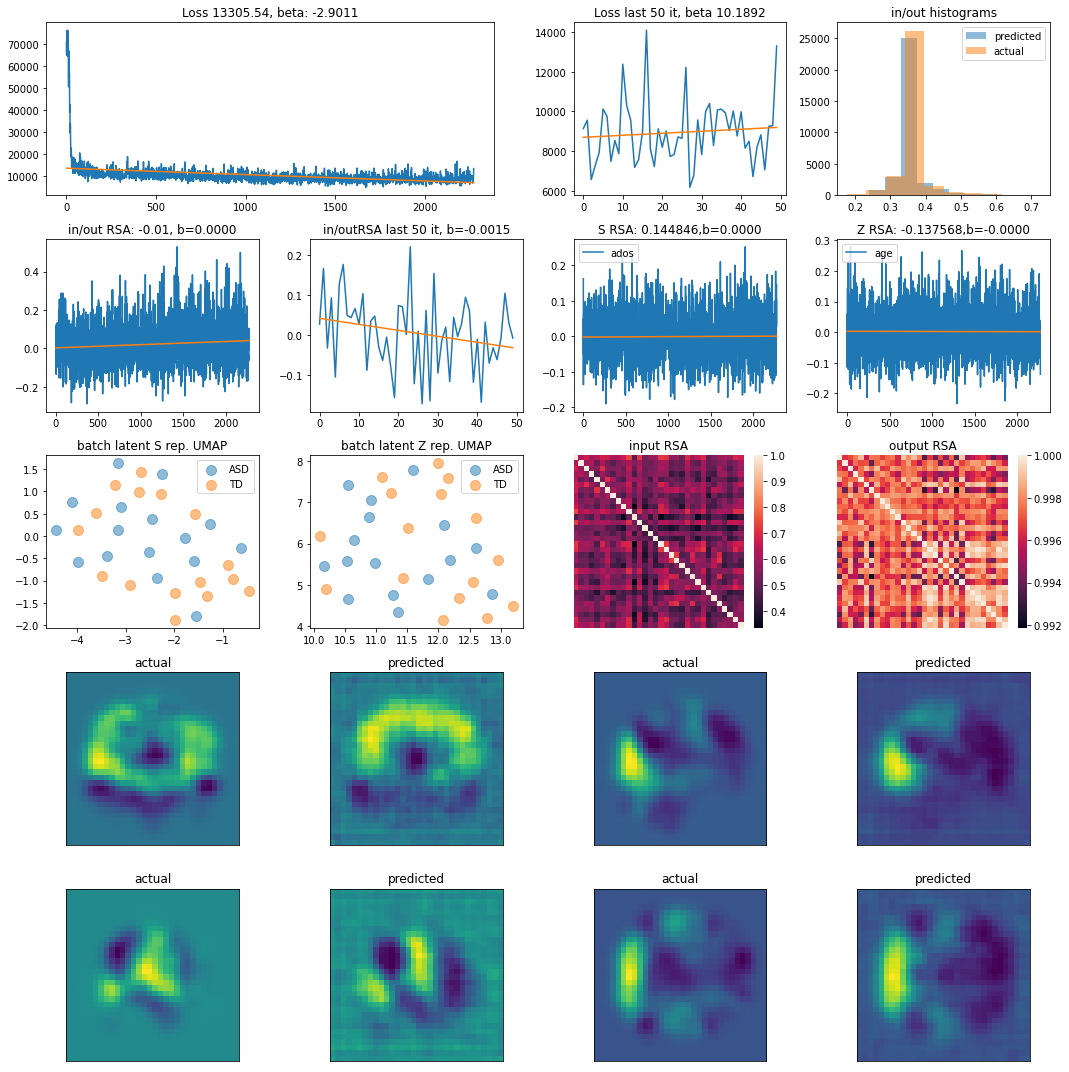

 23%|██▎       | 2274/10000 [11:07:49<37:25:52, 17.44s/it]

In [26]:
for i in tqdm(range(10000),position=0, leave=True):
    
    patient_batch = data[patients,:,:,:,:][np.random.randint(low=0,high=patients.sum(),size=batch_size),:,:,:,:]
    control_batch = data[controls,:,:,:,:][np.random.randint(low=0,high=controls.sum(),size=batch_size),:,:,:,:]
    hist = cvae.train_on_batch([patient_batch,control_batch])
    assert not np.isnan(hist),'loss is NaN - you f**cked up'    
    loss.append(hist)
    
    c_sim,all_rsas = cvae_dashboard(i,cvae,z_encoder,s_encoder,loss,all_rsas,c_sim,df,patient_batch,control_batch,red='UMAP')

In [ ]:
# def strip_num(lbl):
#     lbl = lbl.replace('sub-','')
#     return ''.join([letter for letter in lbl if letter.isalpha()])

# def str2ord(arr):
#     #arr = np.array(sites)
#     u = np.unique(arr)
#     ord_arr = np.zeros(arr.shape)
#     for i in range(len(u)):
#         ord_arr[arr==u[i]]=i+1
#     return ord_arr

# sites = [strip_num(lbl) for lbl in df['bids_folder'].values]
# df['site'] = str2ord(np.array(sites))
# #plt.imshow(make_RDM(df['site'].values,data_scale='ordinal'))
# #make_RDM(df['site'].values)
# #make_RDM(df['AGE_AT_SCAN'].values)